# Exercise Sheet 4 - Transfer Learning for Saliency Prediction

 * Deep Learning – Winter term 2019/20
 * Instructor: Prof. Dr. Alexander Ecker
 * Tutor: Timo Janßen (<timo.janssen@theorie.physik.uni-goettingen.de>)
 * Due date: Jan 20, 2020 at noon

In this assignment you will learn how to use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of only 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is.

**Importing required libraries.**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

**Get the data**

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html

For your convenience there is a shared folder on Google Drive: https://drive.google.com/drive/folders/1GoYw3jp9kWLmHN7qylDS5QTo_ebnaMDD?usp=sharing
You can click the link and add the folder to your Drive (it does not count into your disk quota).

If you're using Colab, you can uncomment the code in the following cell to mount your Google drive. Otherwise, you need to download the data and enter the path to it.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# This notebook and MIT_1003 folder are assumed to be in the same folder
main_path = 'drive/My Drive'
# main_path = '<path>/<to>/<notebook>'
data_path = os.path.join(main_path, 'MIT_1003')


**Prepare the data**

In [4]:
images_files_all  = [os.path.join(f) for f in os.scandir(os.path.join(data_path, 'ALLSTIMULI')) if f.path.endswith('.jpeg') ]
print ("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))


Total Number of Images: 1003 (should be 1003)


In [5]:
# fix the seed for reproducible splitting
np.random.seed(1234)
train_idx = np.random.choice(len(images_files_all), len(images_files_all)//2, replace=False)
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

images_files = {}
images_files['train'] = [images_files_all[i] for i in train_idx]
images_files['test'] = [images_files_all[i] for i in test_idx]
print ("Number of Train Images: {}".format(len(images_files['train'])))
print ("Number of Test Images: {}".format(len(images_files['test'])))

fixation_maps_binary_files = {}
fixation_maps_binary_files['train']  = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixPts.jpg') for filename in images_files['train']]
fixation_maps_binary_files['test']  = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixPts.jpg') for filename in images_files['test']]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files['train'] = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixMap.jpg') for filename in images_files['train']]
fixation_maps_blurred_files['test'] = [os.path.join(data_path, 'ALLFIXATIONMAPS', os.path.splitext(os.path.basename(filename))[0] + '_fixMap.jpg') for filename in images_files['test']]

Number of Train Images: 501
Number of Test Images: 502


**Show an example from the dataset**

In [6]:
image = io.imread(images_files['train'][0])
binary_map = io.imread(fixation_maps_binary_files['train'][0])
blurred_map = io.imread(fixation_maps_blurred_files['train'][0])


True


In [0]:
fixations = np.where(binary_map)

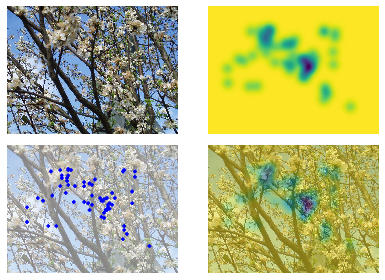

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis('off')
ax1.imshow(image)
ax2.axis('off')
ax2.imshow(blurred_map, cmap='viridis_r')
ax3.axis('off')
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker='.', c='b')
ax4.axis('off')
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap='viridis_r')
fig.tight_layout()

**Preprocess images and maps**

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [0]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                                    torchvision.transforms.Resize(shape), 
                                                    torchvision.transforms.CenterCrop(shape)])
    
    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary
    
    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred
        
    data = {'images': ims, 'fixations_binary': fixs_binary, 'fixations_blurred': fixs_blurred}
    return data

In [0]:
#train_data = preprocess_data(images_files['train'], fixation_maps_binary_files['train'], fixation_maps_blurred_files['train'], 256)
#test_data = preprocess_data(images_files['test'], fixation_maps_binary_files['test'], fixation_maps_blurred_files['test'], 256)

**Save/Load preprocessed data**

If you want to, you can save the data on disk, so that you don't have to generate it again.

In [0]:
train_data_file = os.path.join(main_path, 'train_data.npy')
test_data_file = os.path.join(main_path, 'test_data.npy')
#np.save(train_data_file, train_data)
#np.save(test_data_file, test_data)
train_data = np.load(train_data_file, allow_pickle=True)[()]
test_data = np.load(test_data_file, allow_pickle=True)[()]


**Implement a PyTorch dataset for our data**

This allows us to access the data conveniently and to use it in a dataloader.

In [0]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data
    
    def __getitem__(self, key):
        raw_image = self.data['images'][key]
        
        normalized_image = raw_image.astype(np.float32) / 255.0 # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])     # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])     # divide by SD   
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW
        
        fixations_binary = self.data['fixations_binary'][key]
        fixations_blurred = self.data['fixations_blurred'][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data
    
    def __len__(self):
        return len(self.data['images'])

The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [0]:
def to_sparse(x):
    """ converts dense tensor x to sparse format """
    x_typename = torch.typename(x).split('.')[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())

def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch])
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data

**Compute center bias**

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We incorporate this bias into our model explicitly. 

**TO DO:** To compute the center bias, sum all the binary fixation maps, normalize and apply a Gaussian filter to smooth the result.

In [0]:
from scipy.ndimage import gaussian_filter

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data['fixations_binary']

def centerBias(fb, sig):
  fb_sum = sum(fb) #to get the sum of all the binary fixation maps
  fb_sum = fb_sum.reshape((1,256,256)) #to get the right shape - is there any other solution?
  #maybe the wrong shape, because it is just 256x256 ...
  fb_norm = (fb_sum - fb_sum.mean())/(fb_sum.max() - fb_sum.min()) #Normalization: (x_i - x.mean)(x.max - m´x.min)
  res = gaussian_filter(fb_norm, sigma=sig) #apply a gaussion filter to smooth
  return(res)

center_bias = centerBias(fixations_binary, sig=1)    # (should be 1 x 256 x 256)

Show the result

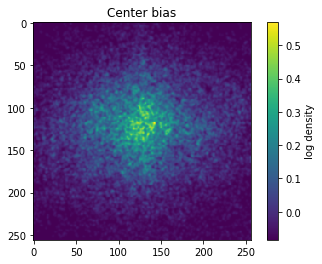

In [15]:
plt.figure()
plt.imshow(center_bias[0])
cb = plt.colorbar().set_label('log density')
plt.title('Center bias');

Save/Load center bias

In [0]:
center_bias_file = os.path.join(main_path, 'center_bias.npy')
#np.save(center_bias_file, center_bias)
center_bias = np.load(center_bias_file)

**Extract feature maps**

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the test dataset and extract the feature maps from the Conv2d layer vgg19.features[30]. You should save them in a Numpy array.


In [17]:
from torch.utils.data import DataLoader
dataset_test = ImageDataset(test_data)
    
vgg = torchvision.models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 77.1MB/s]


torch.Size([502, 512, 28, 28])


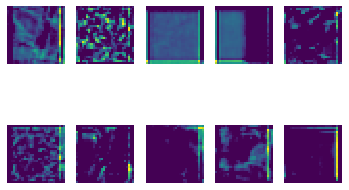

In [27]:
from PIL import Image
from torchvision import transforms

input_batch = []
for i, image in enumerate(dataset_test.data['images']):
    input_image = Image.fromarray(image, mode="RGB")
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch.append(input_tensor.unsqueeze(0))

input_batch = torch.cat(input_batch)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    vgg.to('cuda')

with torch.no_grad():
    output = vgg.features[0:30](input_batch).to("cpu")
    # Ploting example feature 256 from images 0 to 10
    fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5)
    ax1.axis('off')
    ax1.imshow(output[0][256])
    ax2.axis('off')
    ax2.imshow(output[1][256])
    ax3.axis('off')
    ax3.imshow(output[2][256])
    ax4.axis('off')
    ax4.imshow(output[3][256])
    ax5.axis('off')
    ax5.imshow(output[4][256])
    ax6.axis('off')
    ax6.imshow(output[5][256])
    ax7.axis('off')
    ax7.imshow(output[6][256])
    ax8.axis('off')
    ax8.imshow(output[7][256])
    ax9.axis('off')
    ax9.imshow(output[8][256])
    ax10.axis('off')
    ax10.imshow(output[9][256])

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output.shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
features = output

**Save the features to a file**

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [0]:
features_file = os.path.join(main_path, 'features_train.npy')
#np.save(features_file, features)
features = np.load(features_file)

Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [0]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False,
)

**Define the model**

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network
The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer
The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias (don't forget to give a learnable weight to the center bias). Finally it is normalized using a (log) softmax.

In [0]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should 
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """
    
    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape_x = [1] * 4
        kernel_shape_x[3] = self.kernel_size
        grid_x = grid.view(kernel_shape_x)
        self.kernel_x = torch.exp(-0.5 * (grid_x / self.sigma) ** 2)#.cuda()
        self.kernel_x = self.kernel_x / self.kernel_x.sum()

        kernel_shape_y = [1] * 4
        kernel_shape_y[2] = self.kernel_size
        grid_y = grid.view(kernel_shape_y)
        self.kernel_y = torch.exp(-0.5 * (grid_y / self.sigma) ** 2)#.cuda()
        self.kernel_y = self.kernel_y / self.kernel_y.sum()

        
    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        out = F.conv1d(tensor, self.kernel_x, padding=self.pad)
        out = F.conv1d(out, self.kernel_y)

        return out

In [0]:
#TODO
readout_network = 

In [0]:
class Finalizer(nn.Module):
#TODO

In [0]:
class Model(nn.Module):
    
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer
        
    def forward(self, x, centerbias):
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)

In [0]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)

**Define the metrics**

Here we use two different metrics, one for training and one for evaluating the performance of our model. For the training, we use negative log-likelihood (NLL). Implement a function that calculates the log-likelihood of a fixation mask under the model prediction. 

*Hint: You can convert a sparse tensor t to a dense one using t.to_dense().*

In [0]:
def log_likelihood(log_density, fixation_mask):
    #TODO

For evaluation, we want to use the *normalized scanpath saliency* (NSS). NSS is the average of the response values at human eye positions in a model’s saliency map SM(x) that has been normalized to have zero mean and unit standard deviation. That is, we take the values

$Z_{\mathrm{SM}} = \frac{\mathrm{SM}(x) - \mu}{\sigma}$,

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively, and we take the average over all fixations:

$\mathrm{NSS} = \frac{1}{M} \sum_{k=1}^M Z_{\mathrm{SM}}(x_f(k))$. 

Implement this as a function.

In [0]:
def nss(log_density, fixation_mask):
    #TODO

**Train the model**

Now iterate through the dataloader to train the model on the test dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the test dataset after each training epoch to monitor the progress. Train for at least 5 epochs.

In [0]:
def train_model(model, train_dataset, centerbias):
    #TODO

In [0]:
%time train_model(model, data_loader_train, torch.tensor(center_bias, dtype=torch.float))

You can save the model to disk if you want to.

In [0]:
model_file = os.path.join(main_path, 'model_12012020.torch')
torch.save(model.state_dict(), model_file)

Use this to load a model that you've saved previously.

In [0]:
# model.load_state_dict(torch.load(model_file)
# model.eval()

**Inspect the results**

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

In [0]:
test_data = preprocess_data(images_files['test'], fixation_maps_binary_files['test'], fixation_maps_blurred_files['test'], 256)

In [0]:
test_data_file = os.path.join(main_path, 'test_data.npy')
np.save(test_data_file, test_data)
#test_data = np.load(test_data_file, allow_pickle=True)

Here you need to extract the feature maps for the test images. It works the same way as before for the train dataset.

In [0]:
#TODO
features_test = 

In [0]:
features_test_file = os.path.join(main_path, 'features_test.npy')
np.save(features_test_file, features_test)
#features_test = np.load(features_test_file)

In [0]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=1,
    collate_fn=collate_fn,
    pin_memory=False,
)

**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is the best example from our reference implementation:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [0]:
#TODO
scores = 

In [0]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('original image')
    ax2.axis('off')
    ax2.imshow(blurred_map, cmap='viridis_r')
    ax2.set_title('blurred fixation map')
    ax3.axis('off')
    ax3.imshow(prediction, cmap='viridis_r')
    ax3.set_title('model prediction')
    ax4.axis('off')
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker='.', c='b')
    ax4.set_title('overlayed with discrete fixations')
    ax5.axis('off')
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap='viridis_r')
    ax5.set_title('overlayed with original image')
    ax6.axis('off')
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap='viridis_r')
    ax6.set_title('overlayed with original image')
    #fig.tight_layout()

In [0]:
#TODO
#plot(...)

**Display test images with lowest scores**

Here is an example from our reference implementation for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

In [0]:
#TODO